# Convolutional Neural Networsk Project

## Sub-project 1:

## Solve Fashion_MNIST with LeNet architecture

In this project you will implement the LeNet architecture of Convolutional Neural Networks. First you will download the Fashion-MNIST dataset. Split into train/validation/test datasets and train the network. Finally, plot the learning curves (train/validation loss and accuracy) and show the confusion matrix.

In [3]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


### 1. Download Fashion-MNIST

### 2. Split the data into train / validation / test subsets. Make mini-batches, if necesssary.

In [4]:
data = datasets.FashionMNIST(
    root = 'data/fashionmnist',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.FashionMNIST(
    root = 'data/fashionmnist',
    train = False,
    transform = ToTensor()
)

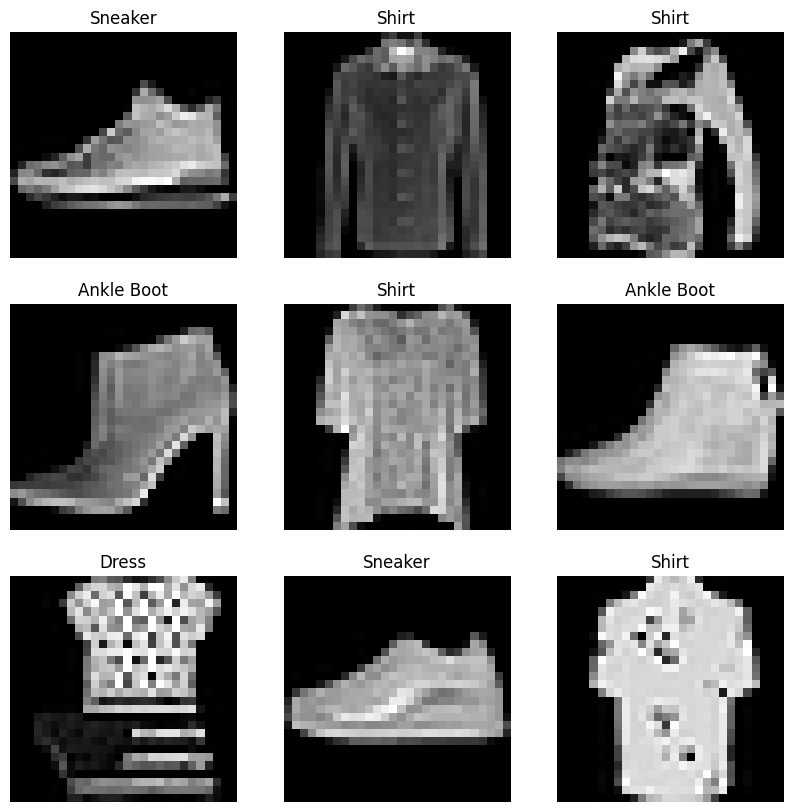

In [5]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(data), size = (1,)).item()
    image, label = data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [6]:
image, label = data[0]
print(f"Image shape: {image.shape}")
print(f"Label: {label}")

Image shape: torch.Size([1, 28, 28])
Label: 9


### 3. Build the LeNet model

In [7]:
# model from slides (closely resemble the true LeNet model but not exactly.

net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
nn.AvgPool2d(kernel_size=2, stride=2),
nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
nn.Linear(120, 84), nn.Sigmoid(), nn.Linear(84, 10))

In [11]:

# Define relevant variables for the ML task
batch_size = 100
learning_rate = 0.01
num_epochs = 10
    
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# prepare the loader

# Split 80% train / 20% validation
train_size = int(0.8 * len(data))
val_size = len(data) - train_size
train_set, val_set = random_split(data, [train_size, val_size])

print('dataset: ', str(len(data)))
print('len(train_set): ', str(len(train_set)))
print('len(val_set): ', str(len(val_set)))


# Loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

loaders = {
    'train': train_loader,
    'validation': val_loader,
    'test': test_loader
}

dataset:  60000
len(train_set):  48000
len(val_set):  12000


In [7]:
from torch import optim

loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
net.parameters()
for parameter in net.parameters():
    print(parameter.shape)


torch.Size([6, 1, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])
torch.Size([120, 400])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


In [8]:
net.to(device)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

### 4. Train the model on the dataset

In [9]:
def get_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [10]:
def train(num_epochs, nn, loaders):
  train_losses = [] # bruges til at gemme vores train loss
  val_losses = []   # bruges til at gemme vores validation loss
  accuracy_list = []
    
  min_valid_loss = np.inf

  if torch.cuda.is_available():
    nn.cuda()

  for epoch in range(num_epochs):

    # Train the model
    epoch_train_loss = 0
    # This line tells our NN that it's in the training mode
    # This will become relevant when we introduce layers that behave
    # differently in training and deployment/evaluation modes
    nn.train()
    for i, (images, labels) in enumerate(loaders['train']):
      if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()
      output = nn(images)
      loss = loss_f(output, labels)
      epoch_train_loss += loss.item()

      # clear gradients for this training step
      optimizer.zero_grad()

      # backpropagation, compute gradients
      loss.backward()
      # apply gradients
      optimizer.step()

    # Validate the model
    epoch_val_loss = 0
    nn.eval()
    for images_v, labels_v in loaders['validation']:
      if torch.cuda.is_available():
        images_v, labels_v = images_v.cuda(), labels_v.cuda()
      output = nn(images_v)
      loss_v = loss_f(output, labels_v)
      epoch_val_loss += loss_v.item()

    training_loss = epoch_train_loss / len(loaders['train'])
    validation_loss = epoch_val_loss / len(loaders['validation'])
    accuracy_epoch = get_accuracy(nn, loaders['train'])
    
    train_losses.append(training_loss)
    val_losses.append(validation_loss)
    accuracy_list.append(accuracy_epoch)


    print(f'Epoch {epoch+1}')
    print(f'Training Loss: {training_loss}')
    print(f'Validation Loss: {validation_loss}')
    print(f'Accuracy: {accuracy_epoch}')
    print('-------------------')
    if min_valid_loss > epoch_val_loss:
      print(f'Validation Loss Decreased({min_valid_loss}--->{epoch_val_loss}) \t Saving The Model')
      min_valid_loss = epoch_val_loss
      # Saving State Dict
      torch.save(nn.state_dict(), 'saved_model.pth')
        
  return train_losses, val_losses, accuracy_list #returner de tre lister jeg definerede i begyndelsen



train_losses, val_losses, accuracy_list = train(num_epochs, net, loaders)

Epoch 1
Training Loss: 2.3054798384507498
Validation Loss: 2.303200407822927
Accuracy: 0.10072916666666666
-------------------
Validation Loss Decreased(inf--->276.3840489387512) 	 Saving The Model
Epoch 2
Training Loss: 2.303496254980564
Validation Loss: 2.303571184476217
Accuracy: 0.09933333333333333
-------------------
Epoch 3
Training Loss: 2.30343878865242
Validation Loss: 2.303353347380956
Accuracy: 0.10072916666666666
-------------------
Epoch 4
Training Loss: 2.161938440303008
Validation Loss: 0.9901290441552798
Accuracy: 0.5651666666666667
-------------------
Validation Loss Decreased(276.3840489387512--->118.81548529863358) 	 Saving The Model
Epoch 5
Training Loss: 0.7289618489022056
Validation Loss: 0.5890052596728007
Accuracy: 0.770375
-------------------
Validation Loss Decreased(118.81548529863358--->70.68063116073608) 	 Saving The Model
Epoch 6
Training Loss: 0.5587778207535545
Validation Loss: 0.5258712343871593
Accuracy: 0.7908333333333334
-------------------
Validatio

### 5. Plot the training curves (Loss and accuracy)

In [11]:
def evaluate(model, test_loader):
    model.to(device)           # Ensure model is on the right device
    model.eval()               # Set to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():     # Disable gradient calculation
        for test_imgs, test_labels in test_loader:
            test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)
            output = model(test_imgs)
            predicted = torch.argmax(output, dim=1)
            correct += (predicted == test_labels).sum().item()
            total += test_labels.size(0)

    accuracy = correct / total
    print("Test accuracy: {:.3f}".format(accuracy))

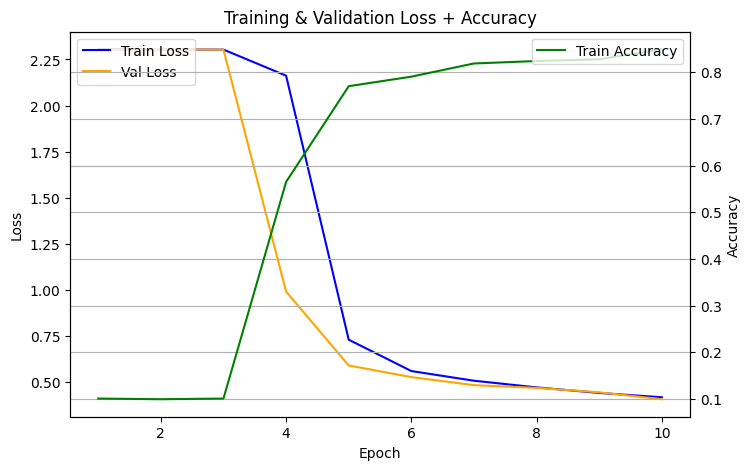

In [12]:
# chatgpt plot:
epochs = range(1, len(train_losses) + 1)

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot losses
ax1.plot(epochs, train_losses, label='Train Loss', color='blue')
ax1.plot(epochs, val_losses, label='Val Loss', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')
ax1.set_title('Training & Validation Loss + Accuracy')

# Plot accuracy on a second y-axis
ax2 = ax1.twinx()
ax2.plot(epochs, accuracy_list, label='Train Accuracy', color='green')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='upper right')

plt.grid(True)
plt.show()

In [13]:
test_acc = get_accuracy(net, loaders['test'])
print(f"Test accuracy: {test_acc:.3f}")

Test accuracy: 0.837


### 6. Show the confusion matrix and accuracy on the test dataset.

### 7. Is LeNet better than the fully connected Neural Network trained in the project from lecture 3? Comment on the results

Answer:

## Sub-project 2:

## Use a pretrained model to solve

In this project you will download the Intel Image Classification dataset (https://www.kaggle.com/puneet6060/intel-image-classification/download).
Find a suitable pretrained Convolutional Neural Network and its weights. Fix the filters and retrain/finetune the top of the network. Show and comment on resuls.

Alternativelly, you can browse Kaggle for some interesting datasets like: Dogs vs Cats, Alien vs Predator, Doom vs Animal Crossing, CelebA, etc. Just don't use something easy like MNIST, Fashion-MNIST, etc.

### 1. Download the data

In [14]:
# done, i have put them locally in data/... folder

### 2. Preprocess the data.

(This might include resizing, augmenting, etc.)




### 3. Split the data (train / test / validation) and make mini-batches.

In [25]:
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms

# Load pretrained weights and their transform
weights = ResNet18_Weights.DEFAULT
base_transform = weights.transforms()

# Wrap with Grayscale conversion by nesting Compose
my_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # convert to 3-channel (RGB as resnet takes - my data has only grayscale 1 channel))
    base_transform                                # apply ResNet18's full transform
])


In [26]:
train_path = "data/seg_train/seg_train"
test_path = "data/seg_test/seg_test"

full_train_dataset = datasets.ImageFolder(train_path, transform=my_transform)
test_dataset = datasets.ImageFolder(test_path, transform=my_transform)

In [27]:
from torch.utils.data import random_split

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_set, val_set = random_split(full_train_dataset, [train_size, val_size])
print('len(train_set)', len(train_set))
print('len(val_set)', len(val_set))

len(train_set) 11227
len(val_set) 2807


In [28]:
img, label = full_train_dataset[0]
print(img.shape) 

torch.Size([3, 224, 224])


In [53]:
# Use the correctly transformed datasets
train_set, val_set = random_split(full_train_dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

resnet_loaders = {
    'train': train_loader,
    'validation': val_loader,
    'test': test_loader
}


In [54]:
import os
print(os.listdir(train_path))


['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


### 4. Download the pretrained architecture and weights.

This part might include some research and understanding of architecures and the type of data they were trained on.

In [55]:
from torchvision import models

pretrained_resnet_model = models.resnet18(pretrained=True)
#print(model)

# What type of data was this trained on?
print(f"Output layer: {pretrained_resnet_model.fc}")

# What input size and normalization does it expect? → 224x224, ImageNet mean/std

weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

print(preprocess)

Output layer: Linear(in_features=512, out_features=1000, bias=True)
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


### 5. Build the larger model that includes the pre-trained part and prepare it for training.

* Show the model summary so you are sure which components are included and how many (un)trainable parameters you have

In [56]:
# Freeze all pretrained layers
for param in pretrained_resnet_model.parameters():
    param.requires_grad = False

num_classes = len(full_train_dataset.classes)
print('num_classes (len):', num_classes)
# Now only new layers I add will be trained.
# my output earlier
# Class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
# Num classes: 6
pretrained_resnet_model.fc = nn.Linear(512, num_classes) # num_classes is 6, so this means we want to predict either one of the 6
# normally resnet is 1000 because it contains 1000 different objects / classifications

num_classes (len): 6


### 6. Train the trainable part of the model

In [57]:
def get_accuracy_macbook(model, loader, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total


In [58]:
from torch import optim

loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_resnet_model.parameters(), lr=0.001)
net.parameters()
for parameter in pretrained_resnet_model.parameters():
    print(parameter.shape)

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 64, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 128, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
t

In [60]:
def train_macbook(num_epochs, model, loaders):
    import torch
    import numpy as np

    train_losses = []
    val_losses = []
    accuracy_list = []

    min_valid_loss = np.inf

    # Use MPS if available (for Apple Silicon)
    device = torch.device("mps" if torch.backends.mps.is_available()
                          else "cuda" if torch.cuda.is_available()
                          else "cpu")
    print("Using device:", device)

    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0

        for images, labels in loaders['train']:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = loss_f(output, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        # Validation
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for images_v, labels_v in loaders['validation']:
                images_v, labels_v = images_v.to(device), labels_v.to(device)
                output = model(images_v)
                loss_v = loss_f(output, labels_v)
                epoch_val_loss += loss_v.item()

        training_loss = epoch_train_loss / len(loaders['train'])
        validation_loss = epoch_val_loss / len(loaders['validation'])
        accuracy_epoch = get_accuracy_macbook(model, loaders['train'], device)

        train_losses.append(training_loss)
        val_losses.append(validation_loss)
        accuracy_list.append(accuracy_epoch)

        print(f'Epoch {epoch+1}')
        print(f'Training Loss: {training_loss:.4f}')
        print(f'Validation Loss: {validation_loss:.4f}')
        print(f'Accuracy: {accuracy_epoch:.2f}%')
        print('-------------------')

        if min_valid_loss > epoch_val_loss:
            print(f'Validation Loss Decreased({min_valid_loss:.4f} → {epoch_val_loss:.4f}) — Saving model')
            min_valid_loss = epoch_val_loss
            torch.save(model.state_dict(), 'saved_model.pth')

    return train_losses, val_losses, accuracy_list


In [61]:
images, labels = next(iter(resnet_loaders['train']))
print(images.shape)

torch.Size([16, 3, 224, 224])


In [62]:
train_losses, val_losses, accuracy_list = train_macbook(10, pretrained_resnet_model, resnet_loaders)

Using device: mps
Epoch 1
Training Loss: 0.6052
Validation Loss: 0.3569
Accuracy: 87.25%
-------------------
Validation Loss Decreased(inf → 62.8160) — Saving model
Epoch 2
Training Loss: 0.4234
Validation Loss: 0.3399
Accuracy: 88.48%
-------------------
Validation Loss Decreased(62.8160 → 59.8144) — Saving model
Epoch 3
Training Loss: 0.4058
Validation Loss: 0.3617
Accuracy: 87.66%
-------------------
Epoch 4
Training Loss: 0.3799
Validation Loss: 0.3397
Accuracy: 88.71%
-------------------
Validation Loss Decreased(59.8144 → 59.7933) — Saving model
Epoch 5
Training Loss: 0.3760
Validation Loss: 0.3293
Accuracy: 89.38%
-------------------
Validation Loss Decreased(59.7933 → 57.9588) — Saving model
Epoch 6
Training Loss: 0.3740
Validation Loss: 0.3142
Accuracy: 90.11%
-------------------
Validation Loss Decreased(57.9588 → 55.3056) — Saving model
Epoch 7
Training Loss: 0.3654
Validation Loss: 0.3145
Accuracy: 90.12%
-------------------
Epoch 8
Training Loss: 0.3643
Validation Loss: 0.

### 7. Show the training plots and confusion matrix

### Finetune the model and show the plots, test data confusion matrix and accuracy.

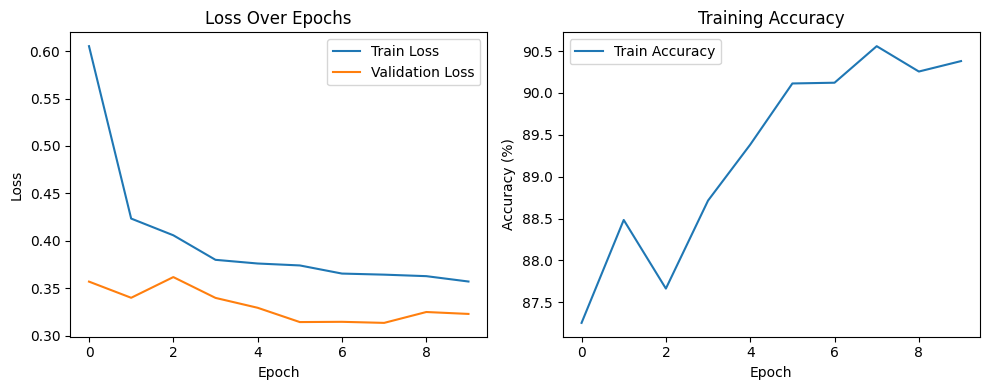

In [63]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy_list, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

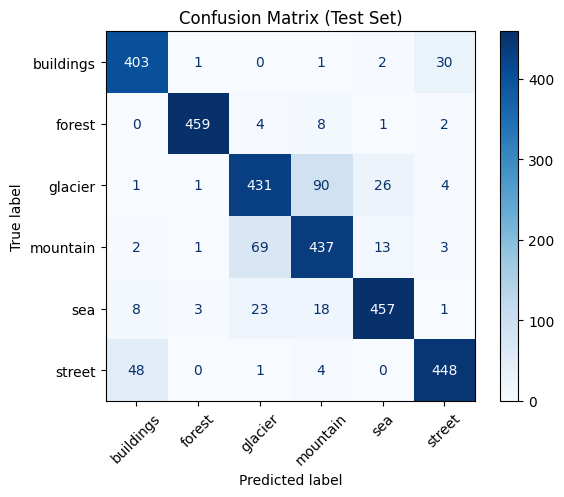

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import numpy as np
class_names = full_train_dataset.classes
# Get device
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")

# Make predictions
model = pretrained_resnet_model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in resnet_loaders['test']:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.show()


### 9. Comment on the results. Are the results to your satisfaction? Which phase contributed to the improved performance? What was the most challenging aspect of the exercise? Ideas for improving the model?

In [66]:
from torchvision.models import resnet18
import torch

# Recreate the model
model = resnet18()
model.fc = torch.nn.Linear(512, num_classes)  # Same shape as during training

# Load the weights
model.load_state_dict(torch.load("saved_model.pth"))
#model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Answer: